In [85]:
import os
import dicom
import numpy as np
import pandas as pd
import itertools as it
import matplotlib.pyplot as plt
import collections
from scipy.ndimage.interpolation import zoom
from scipy.misc import imresize

from glob import glob
from sklearn.metrics import log_loss

%matplotlib inline

In [26]:
use_sample = True

images_dir = 'data/sample_images/'
if not use_sample:
    # real data
    images_dir = 'data/images/stage1/'
    labels = pd.read_csv('data/stage1_labels.csv')

In [151]:
def load_scan(patient_id):
    dicom_files = glob(os.path.join(images_dir, patient_id, '*.dcm'))
    slices = [dicom.read_file(f) for f in dicom_files]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    return slices

def rescale(slices):
    # normalise pixel array values (HU units?)
    image = np.stack([s.pixel_array for s in slices])
    image = image.astype(np.int16)
    image[image == -2000] = 0 # 0 + intercept = 0 + -1024 = -1024 (air)
    for slice_idx in range(len(slices)):
        image[slice_idx] *= np.int16(slices[slice_idx].RescaleSlope) # slope
        image[slice_idx] += np.int16(slices[slice_idx].RescaleIntercept) # intercept
    return image

def resample(image, slices):
    # make distance between pixels 1mm
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)

    for s in slices:
        s.SliceThickness = slice_thickness
    
    current_shape = np.array([slices[0].SliceThickness] + slices[0].PixelSpacing, dtype=np.float32)
    new_image = zoom(image, current_shape, mode='nearest', order=0)
    return new_image

def normalise(image):
    minimum = np.min(image)
    maximum = np.max(image)
    new_image = (image - minimum) / (maximum - minimum)
    # ni -= 0.25 # global pixel mean
    return new_image

def preprocess(patient_id):
    slices = load_scan(patient_id)
    original_image = rescale(slices) # 3D image
    new_image = resample(original_image, slices)
    new_image = normalise(new_image)
    new_image = np.swapaxes(new_image, 0, 2)
    new_image = np.reshape(new_image, new_image.shape + (1,))
    return new_image

def get_patient_label(patient_id):
    try:
        return labels[labels['id'] == patient_id]['cancer']
    except:
        return 1

def image_generator(patient_ids):
    for patient_id in patient_ids:
        yield preprocess(patient_id)

def label_generator(patient_ids):
    for patient_id in patient_ids:
        yield get_patient_label(patient_id)
        
def batch_generator(X, Y, batch_size=32):
    while True:
        yield tuple(it.islice(X, 0, batch_size)), \
              tuple(it.islice(Y, 0, batch_size))

In [163]:
pid = sample_ids[1]

In [164]:
slices = load_scan(pid)

In [165]:
original_image = rescale(slices) # 3D image

In [159]:
original_image.shape

(164, 512, 512)

In [166]:
original_image.shape

(113, 512, 512)

In [167]:
new_image = resample(original_image, slices)

/home/ubuntu/conda/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [168]:
new_image.shape

(282, 308, 308)

In [162]:
new_image.shape

(328, 360, 360)

In [152]:
sample_ids

['0c37613214faddf8701ca41e6d43f56e',
 '0de72529c30fe642bc60dcb75c87f6bd',
 '0a099f2549429d29b32f349e95fb2244',
 '00cba091fa4ad62cc3200a657aeb957e',
 '0c9d8314f9c69840e25febabb1229fa4',
 '0bd0e3056cbf23a1cb7f0f0b18446068',
 '0c0de3749d4fe175b7a5098b060982a1',
 '0d06d764d3c07572074d468b4cff954f',
 '0c59313f52304e25d5a7dcf9877633b1',
 '0c98fcb55e3f36d0c2b6507f62f4c5f1',
 '0ca943d821204ceb089510f836a367fd',
 '0a0c32c9e08cc2ea76a71649de56be6d',
 '0ddeb08e9c97227853422bd71a2a695e',
 '0d19f1c627df49eb223771c28548350e',
 '0b20184e0cd497028bdd155d9fb42dc9',
 '0acbebb8d463b4b9ca88cf38431aac69',
 '0a38e7597ca26f9374f8ea2770ba870d',
 '0c60f4b87afcb3e2dfa65abbbf3ef2f9',
 '0d2fcf787026fece4e57be167d079383',
 '0d941a3ad6c889ac451caf89c46cb92a']

In [146]:
train_batches = batch_generator(image_generator(sample_ids),
                                    label_generator(sample_ids),
                                    batch_size)

In [147]:
X, y = next(train_batches)

/home/ubuntu/conda/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [150]:
X[2][:,:,:,-1].shape

(347, 347, 320)

In [141]:
img = imresize(X[0][:,:,-1,-1], (256, 256), interp='nearest')

ValueError: 'arr' does not have a suitable array shape for any mode.

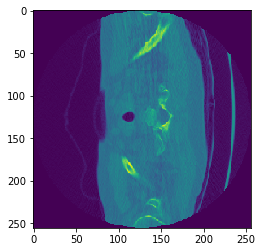

In [137]:
plt.imshow(img)

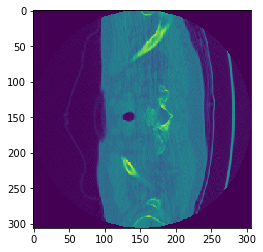

In [135]:
plt.imshow(X[0][:,:,-1,-1])

**Organise patient ids into train, valid and test**

In [60]:
if use_sample:
    sample_ids = [i for i in os.listdir(images_dir) if len(i) == 32]
else:
    # split ids into train and valid
    valid_percent = 0.15
    pos = labels[labels['cancer'] == 1]
    neg = labels[labels['cancer'] == 0]
    pos_valid_ids = set(pos.sample(frac=valid_percent)['id'])
    neg_valid_ids = set(neg.sample(frac=valid_percent)['id'])
    pos_train_ids = set(pos['id']).difference(pos_valid_ids)
    neg_train_ids = set(neg['id']).difference(neg_valid_ids)

    print((len(pos_train_ids), len(neg_train_ids), len(pos_valid_ids), len(neg_valid_ids)))

    pos_train_ids = list(pos_train_ids)
    neg_train_ids = list(neg_train_ids)
    pos_valid_ids = list(pos_valid_ids)
    neg_valid_ids = list(neg_valid_ids)
    np.random.shuffle(pos_train_ids)
    np.random.shuffle(neg_train_ids)
    np.random.shuffle(pos_valid_ids)
    np.random.shuffle(neg_valid_ids)

**Define the model**

In [29]:
from tensorflow.python.client import device_lib
import tensorflow as tf

from keras.models import Model
from keras import layers
from keras.layers import Activation
from keras.layers import Dense
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Conv3D
from keras.layers import MaxPooling3D
from keras.layers import AveragePooling3D
from keras.layers import GlobalAveragePooling3D
from keras.layers import GlobalMaxPooling3D
from keras.engine.topology import get_source_inputs
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import _obtain_input_shape
from keras.preprocessing import image as k_image

import pandas as pd
import numpy as np

print('Input tensor ordering:', K.image_data_format())
print(device_lib.list_local_devices())

Input tensor ordering: channels_last
[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13311331902530126602
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 384565248
locality {
  bus_id: 1
}
incarnation: 4982206592896761432
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0"
]


In [30]:
# https://github.com/fchollet/deep-learning-models/blob/master/inception_v3.py
channel_axis = 4

def conv_block(x, filters, h, w, z, padding='same', strides=(1, 1, 1)):
    x = Conv3D(filters,
               (h, w, z), # height, width, z
               strides=strides,
               padding=padding,
               use_bias=False)(x)
    x = BatchNormalization(axis=channel_axis, scale=False)(x) # batch norm axis=4 ??
    x = Activation('relu')(x)
    return x

def inception_block(x):
    
    x = conv_block(x, 32, 3, 3, 3, strides=(2, 2, 2), padding='valid')
    x = conv_block(x, 32, 3, 3, 3, padding='valid') # padding same or valid ??
    x = conv_block(x, 64, 3, 3, 3)
    x = MaxPooling3D((3, 3, 3), strides=(2, 2, 2))(x)

    x = conv_block(x, 80, 1, 1, 1, padding='valid')
    x = conv_block(x, 192, 3, 3, 3, padding='valid')
    x = MaxPooling3D((3, 3, 3), strides=(2, 2, 2))(x)

    branch1 = conv_block(x, 64, 1, 1, 1)

    branch5 = conv_block(x, 48, 1, 1, 1)
    branch5 = conv_block(branch5, 64, 5, 5, 5)

    branch3 = conv_block(x, 64, 1, 1, 1)
    branch3 = conv_block(branch3, 96, 3, 3, 3)
    branch3 = conv_block(branch3, 96, 3, 3, 3)

    branch_pool = AveragePooling3D((3, 3, 3), strides=(1, 1, 1), padding='same')(x)
    branch_pool = conv_block(branch_pool, 32, 1, 1, 1)
    
    x = layers.concatenate(
            [branch1, branch5, branch3, branch_pool],
            axis=channel_axis)
    return x

In [61]:
tf.reset_default_graph()

model_input = Input(shape=(None, None, None, 1)) # (x, y, z, channels)
x = inception_block(model_input)
x = GlobalAveragePooling3D(name='avg_pool')(x)
model_output = Dense(1, activation='softmax', name='predictions')(x)
model = Model(model_input, model_output, name='moses')
model.compile(optimizer='rmsprop', # change to Adam() or even Eve() ??
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary(line_length=125)

_____________________________________________________________________________________________________________________________
Layer (type)                             Output Shape               Param #        Connected to                              
input_1 (InputLayer)                     (None, None, None, None, 1 0                                                        
_____________________________________________________________________________________________________________________________
conv3d_1 (Conv3D)                        (None, None, None, None, 3 864                                                      
_____________________________________________________________________________________________________________________________
batch_normalization_1 (BatchNormalizatio (None, None, None, None, 3 96                                                       
______________________________________________________________________________________________________________________

**Train model**

In [67]:
batch_size = 3

In [68]:
if use_sample:
    train_batches = batch_generator(image_generator(sample_ids),
                                    label_generator(sample_ids),
                                    batch_size)
else:
    train_patient_ids = pos_train_ids + neg_train_ids
    valid_patient_ids = pos_valid_ids + neg_valid_ids
    train_batches = batch_generator(image_generator(train_patient_ids),
                                    label_generator(train_patient_ids),
                                    batch_size)
    valid_batches = batch_generator(image_generator(valid_patient_ids),
                                    label_generator(valid_patient_ids),
                                    batch_size)

In [69]:
next(train_batches)

/home/ubuntu/conda/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [64]:
if use_sample:
    num_batches = len(sample_ids) // batch_size + 1
    model.fit_generator(
        generator=train_batches,
        steps_per_epoch=num_batches,
        epochs=1)
else:
    model.fit_generator(
        generator=train_batches,
        steps_per_epoch=100,
        epochs=1)

Epoch 1/1


/home/ubuntu/conda/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
Exception in thread Thread-8:
Traceback (most recent call last):
  File "/home/ubuntu/conda/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/conda/lib/python3.5/threading.py", line 862, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/conda/lib/python3.5/site-packages/keras/engine/training.py", line 606, in data_generator_task
    generator_output = next(self._generator)
  File "<ipython-input-59-c3c36e76a682>", line 64, in batch_generator
    yield np.vstack(tuple(it.islice(X, 0, batch_size))),               np.vstack(tuple(it.islice(Y, 0, batch_size)))
  File "/home/ubuntu/conda/lib/python3.5/site-packages/numpy/core/sha

ValueError: output of generator should be a tuple `(x, y, sample_weight)` or `(x, y)`. Found: None